# Google Earth Engine

## Python API

This is the notebook for the tutorial that can be found [here](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard).

*Importing the API*

To install the API, we need to type in our terminal

```
conda install -c conda-forge earthengine-api
```


In [1]:
import ee

Authenticate to the Google Earth Engine servers

In [2]:
ee.Authenticate()


Successfully saved authorization token.


To authenticate, you need to log in with your Google account and paste the generated code in the dialog box that appears in the Jupyter Notebook. Now we initialize the API

In [4]:
ee.Initialize()

Testing the API, we are going to print metadata for a DEM dataset

In [5]:
# Print metadata for a DEM dataset.
print(ee.Image('USGS/SRTMGL1_003').getInfo())

{'type': 'Image', 'bands': [{'id': 'elevation', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [1296001, 417601], 'crs': 'EPSG:4326', 'crs_transform': [0.0002777777777777778, 0, -180.0001388888889, 0, -0.0002777777777777778, 60.00013888888889]}], 'id': 'USGS/SRTMGL1_003', 'version': 1605362602494378, 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'Image', 'thumb': 'https://mw1.google.com/ges/dd/images/SRTM90_V4_thumb.png', 'description': '<p>The Shuttle Radar Topography Mission (SRTM, see <a href="http://onlinelibrary.wiley.com/doi/10.1029/2005RG000183/full">Farr\net al. 2007</a>)\ndigital elevation data is an international research effort that\nobtained digital elevation models on a near-global scale. This\nSRTM V3 product (SRTM Plus) is provided by NASA JPL\nat a resolution of 1 arc-second (approximately 30m).</p><p>This dataset has undergone a void-filling process using open-source data\n(ASTER GDEM2, GMTED2010, a

## Getting Started with Collections

In the Earth Engine Data Catalog, datasets can be of different types:

- Features which are geometric objects with a list of properties. For example, a watershed with some properties such as name and area, is an `ee.Feature`.

- Images which are like features, but may include several bands. For example, the ground elevation given by the USGS [here](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) is an `ee.Image`.

- Collections which are groups of features or images. For example, the Global Administrative Unit Layers giving administrative boundaries is a `ee.FeatureCollection` and the MODIS Land Surface Temperature dataset is an `ee.ImageCollection`.

If you want to know more about different data models, you may want to visit the [Earth Engine User Guide](https://developers.google.com/earth-engine).

In the following sections, we work with the MODIS land cover (LC), the MODIS land surface temperature (LST) and with the USGS ground elevation (ELV), which are `ee.ImageCollections`. The dataset descriptions provide us with all the information we need to import and manipulate these datasets: the availability, the provider, the Earth Engine Snippet, and the available bands associated with images in the collection.

Now, to import the LC, LST and ELV collections, we can copy and paste the Earth Engine Snippets:


In [6]:
# Import MODIS land cover collection
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image
elv = ee.Image('USGS/SRTMGL1_003')




All of these images come in a different resolution, frequency, and possibly projection, ranging from daily images in a 1 km resolution for LST (hence an `ee.ImageCollection` — a collection of several `ee.Images`) to a single image representing data for the year 2000 in a 30 m resolution for the ELV. While we need to have an eye on the frequency, GEE takes care of resolution and projection by resampling and reprojecting all data we are going to work with to a common projection (learn more about projections in Earth Engine). We can define the resolution (called scale in GEE) whenever necessary and of course have the option to force no reprojection.

As you can see in the description of the datasets, they include several sets of information stored in several bands. For example, these bands are associated with the LST collection:

- `LST_Day_1km`: Daytime Land Surface Temperature
- `Day_view_time`: Local time of day observation
- `LST_Night_1km`: Nighttime Land Surface Temperature
- etc.

The description page of the collection tells us that the name of the band associated with the daytime LST is `LST_Day_1km` which is in units of Kelvin. In addition, values are ranging from 7,500 to 65,535 with a corrective scale of 0.02.

Then, we have to **filter the collection on the period of time we want**. We can do that using the `filterDate()` method. We also need to select the bands we want to work with. Therefore, we decide to focus on daytime LST so we select the daytime band `LST_Day_1km` and its associated quality indicator `QC_Day` with the `select()` method.

In [7]:
# Initial date of interest
i_date = '2017-01-01'

# Final date of interest
f_date = '2020-01-01'

# Selection of appropriate bands and dates
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

Now, we can either upload existing shape files or define some points with longitude and latitude coordinates where we want to know more about LC, LST and ELV. For this example, let's use two point locations:

- The first one in the urban area of Lyon, France
- The second one, 30 kilometers away from the city center, in a rural area


In [8]:
# Define the urban location (Lyon)
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

We can easily get information about our region/point of interest using the following methods (to get more information about available methods and required arguments, please visit the API documentation [here](https://developers.google.com/earth-engine/api_docs)):

- `sample()`: samples the image (does **NOT** work for an `ee.ImageCollection` — we'll talk about sampling an `ee.ImageCollection` later) according to a given geometry and a scale (in meters) of the projection to sample in. It returns an `ee.FeatureCollection`.
 - `first()`: returns the first entry of the collection,
 - `get()`: to select the appropriate band of your Image/Collection,
 - `getInfo()`: evaluates server-side expression graph and transfers result to client.

Then we can query the ground elevation and LST around our point of interest using the following commands. Please be careful when evaluating LST. According to the dataset description, the value should be corrected by a factor of 0.02 to get units of Kelvin (do not forget the conversion). To get the mean multi-annual daytime LST, we use the `mean()` collection reduction method on the LST `ee.ImageCollection`. (The following run might take about 15-20 seconds)

In [9]:
scale = 1000 # in Meters

# Print the elevation in Lyon
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point: ', elv_urban_point, ' m.')

# Calculate and print the mean value of the LST collection at the point
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Avg daytime LST at urban point: ', round(lst_urban_point*0.02 - 273.15, 2), 'Celsius')

# Print land cover type at the point
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is: ', lc_urban_point)

Ground elevation at urban point:  196  m.
Avg daytime LST at urban point:  23.12 Celsius
Land cover value at urban point is:  13


## Getting a Time Series

Now that we have seen how to get geospatial information about a place of interest pretty easily, we may want to inspect a time series, probably make some charts and calculate statistics about a place. Hence, we import the data at the given location usign the `getRegion()` method.

In [12]:
# Buffer zone to consider around each point (in meters)
point_buffer = 1000 

# Get the data for the point in urban area
lst_u_poi = lst.getRegion(u_poi, point_buffer).getInfo()

# Get the data for the point in rural area
lst_r_poi = lst.getRegion(r_poi, point_buffer).getInfo()

# Preview the result
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01', 4.810478346460038, 45.77365530231022, 1483228800000, None, 2],
 ['2017_01_02', 4.810478346460038, 45.77365530231022, 1483315200000, None, 2],
 ['2017_01_03', 4.810478346460038, 45.77365530231022, 1483401600000, None, 2],
 ['2017_01_04',
  4.810478346460038,
  45.77365530231022,
  1483488000000,
  13808,
  17]]

Printing the first 5 lines of the result shows that we now have arrays full of data. As we can see several `None` values appear in the `LST_Day_1km` column. The associated quality indicator `QC_Day` indicates a value of 2 meaning that the LST is not calculated because of cloud effects.

We now define a function to transform this array into a `pandas` `DataFrame` which is much more convenient to manipulate

In [13]:
import pandas as pd 

def ee_array_to_df(arr, list_of_bands):
    """
    Transform client-side ee.Image.getRegion() array to pandas.DataFrame
    """
    df = pd.DataFrame(arr)

    # Rearrange header
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns = headers)

    # Remove rows without data inside
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors = 'coerce')

    # Convert the time field into a datetime
    df['datetime'] = pd.to_datetime(df['time'], unit = 'ms')

    # Keep columns of interest
    df = df[['time', 'datetime', *list_of_bands]]

    return df

Apply the function to get the time series we want and print one of them

In [14]:
lst_df_urban = ee_array_to_df(lst_u_poi, ['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """
    Convert MODIS LST units to degrees celsius
    """
    t_celsius = 0.02*t_modis - 273.15
    return t_celsius

# Apply function to get temperature in celsius
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point
lst_df_rural = ee_array_to_df(lst_r_poi, ['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
3,1483488000000,2017-01-04,3.01
4,1483574400000,2017-01-05,2.39
5,1483660800000,2017-01-06,0.89
6,1483747200000,2017-01-07,-0.11
15,1484524800000,2017-01-16,2.33


Now that we have the data in good shape, we can easily make plots and compare the trends. As the area of Lyon experiences a semi-continental climate, we expect that LST has a seasonality influence and the sinusoidal trend describe by [Stallman (1965)](https://doi.org/10.1029/JZ070i012p02821) reading as follows:

$$
LST(t) = LST_0 + \frac{\Delta_{LST}}{2} \sin\left(\frac{2\pi t}{\tau} + \phi\right)
$$

where:

- $LST_0$ represents the mean annual LST,
- $\Delta_{LST}$ represents the amplitude between the maximal and minimal LST,
- $\tau$ represents the period of oscillation of LST, and
- $\phi$ represents an offset needed to adjust the time when $LST(t) = LST_0$

Consequently, on the top of the data scatter plot, we plot the fitting cuirve using the `scipy` library

In [15]:
import matplotlib.pyplot as plt 
import numpy as np 
from scipy import optimize 

# == Fitting curves === #
# Extract x values (times) from the dfs
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))

# Extract y values (LST) from the dfs
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))

# Define the fitting function with parameters
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

# Optimize parameters with a good initial point
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000 #milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau # Offset regarding when we expect LST(t) = LST0
init_vals = [lst0, delta_lst, tau, phi]

params_u, params_covariance_u = optimize.curve_fit(fit_func, x_data_u, y_data_u, p0 = init_vals)
params_r, params_covariance_r = optimize.curve_fit(fit_func, x_data_r, y_data_r, p0 = init_vals)

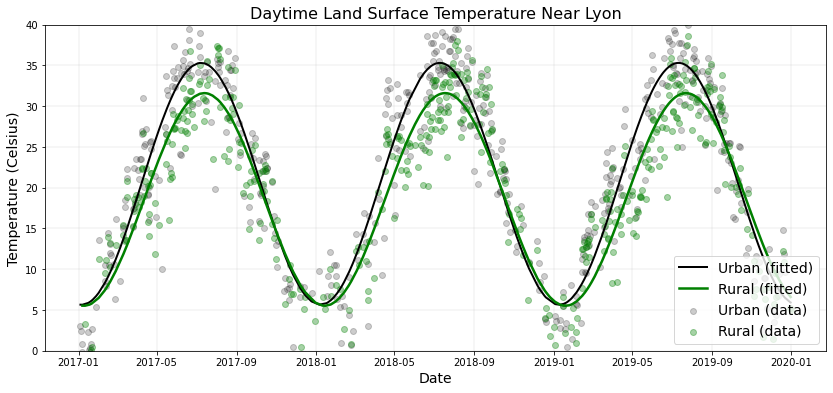

In [16]:
# === PLOT === #
fig, ax = plt.subplots(figsize = (14, 6))

ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
            c = 'black', alpha = 0.2, label = 'Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
            c = 'green', alpha = 0.35, label = 'Rural (data)')

# Add fitting curves
fitted_urban = fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3])
fitted_rural = fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3])

ax.plot(lst_df_urban['datetime'], fitted_urban, label = 'Urban (fitted)',
                        color = 'black', lw = 2)
ax.plot(lst_df_rural['datetime'], fitted_rural, label = 'Rural (fitted)',
                        color = 'green', lw = 2.5)

# Tweak some parameters
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize = 16)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Temperature (Celsius)', fontsize = 14)
ax.set_ylim(-0, 40)
ax.grid(lw = 0.2)
ax.legend(fontsize = 14, loc = 'lower right')
plt.show()

## Static Maps

### Getting a static map 

Get a static map of land surface temperature and ground elevation around a region of interest. We define this region of interest using a buffer zone of 1000km around Lyon.

In [17]:
roi = u_poi.buffer(1e6)

We also have to convert the LST `ee.ImageCollection` into an `ee.Image`, for example by taking the mean value of each pixel over the period of interest. And we convert the value of pixels into Celsius.

In [18]:
# Reduce the LST Collection by mean
lst_img = lst.mean()

# Adjust for scale factor
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

Then, we use the `getThumbUrl()` method to get a URL and we can use the `IPython` library to display the mean daytime LST map for the region of interest. Blue represents the coldest areas ($< 10$C) and red represents the warmest areas ($> 30$C) (note that it may take a moment for the image to load after the cell completes execution).

In [19]:
from IPython.display import Image 

# Create an URL to the styled image for a region around France
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France
print('\n Please wait while the thumbnail loads, it may take a moment')
Image(url = url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5cebb3f64f86a0aca31448809c365349-61c27ebaffaab6dee0dd68af1db0fc79:getPixels

 Please wait while the thumbnail loads, it may take a moment


Let's do the same for a buffer around Brasilia

In [23]:
br_lat, br_lon = -15.797941641091517, -47.882433161438534
br_poi = ee.Geometry.Point(br_lon, br_lat)

br_roi = br_poi.buffer(3.5e6)

url_br = lst_img.getThumbUrl({
    'min': 12, 'max': 40, 'dimensions': 512, 'region': br_roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})

Image(url = url_br)


### Clip an image by a region of interest

We can clip the dataset using the region as an argument of the `clip()` method. We can get the administrative boundaries of Brazil with the FAO feature collection and do the same as before

In [24]:
# Get countries boundaries
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter by country
brazil = countries.filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))

# Clip image by Brazil's boundaries
br_tmp = lst_img.clip(brazil)

url_br_clipped = br_tmp.getThumbUrl({
    'min': 12, 'max': 40, 'dimensions': 512, 'region': br_roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})

Image(url = url_br_clipped)


## Export a GeoTIFF File

After manipulating Earth Engine datasets, you may need to export a resulting ee.Image to a GeoTIFF. For example, to use it as an input of a numerical model outside of Earth Engine, or to overlap it with personal georeferencend files in your favorite GIS. There are multiple ways to do that (see the Exporting section of the Developer Guide). Here we explore two options:

- Save the ee.Image you want in Google Drive
- Directly download the image.

### Save a GeoTIFF file in your Google Drive

To export the `ee.Image` to Google Drive, we have to define a task and start it. We have to specify the size of pixels (here 30 m), the projection (here EPSG:4326), the file format (here GeoTIFF), the region of interest (here the area of Lyon defined before), and the file will be exported to the Google Drive directory head and named according to the `fileNamePrefix` we choose.


In [27]:
task = ee.batch.Export.image.toDrive(image=br_tmp,
                                     description='brazil_avg_temp',
                                     scale=1000,
                                     region=br_roi,
                                     fileNamePrefix='brazil_avg_temperature',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

In [37]:
task.status()

{'state': 'COMPLETED',
 'description': 'brazil_avg_temp',
 'creation_timestamp_ms': 1614770871249,
 'update_timestamp_ms': 1614771539117,
 'start_timestamp_ms': 1614770890338,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/'],
 'attempt': 1,
 'id': 'UDXKC6SAEGBARPI3P7NPPIQ6',
 'name': 'projects/earthengine-legacy/operations/UDXKC6SAEGBARPI3P7NPPIQ6'}

### Get a link to download your GeoTIFF

Similarly, we can use the `getDownloadUrl()` method and click on the provided link. Please note the following points:

- For large or long-running exports, using the `ee.batch.Export` module (previous section) is a better method.
- The token to generate the Earth Engine layer tiles expires after about a day.


In [33]:
lyon = u_poi.buffer(1e4) # 10km around Lyon
link = lst_img.getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': lyon
})

In [34]:
print(link)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3fd162ef4f6a1c071b748296a95b7bb-6b9277cf63d8b0b8eeb7759db6b33062:getPixels
